In [10]:
%matplotlib inline

from __future__ import division

from sklearn import manifold
from sklearn import ensemble
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import forest_cluster as rfc
from forest_cluster import KMedoids
import numpy as np
from scipy.spatial.distance import hamming
import seaborn as sns
import pandas as pd
import time
import scipy.sparse as sp
from classify import get_X_from_elements
from page_data import WebPage

In [18]:
def fast_hamming_binary_dense(X):
    # does a conversion to dense....
    n_features = X.shape[1]
    D = np.dot(1 - X, X.T)
    return (D + D.T) / X.shape[1]


def fast_hamming_binary_sparse(X, n_matches=None):
    if n_matches:
        n_features = n_matches
    else:
        n_features = X.shape[1]
    H = (X * X.T).toarray()
    return 1 - H / n_features


def fast_hamming_dense(X):
    unique_values = np.unique(X)
    U = sp.csr_matrix((X == unique_values[0]).astype(np.int32))
    H = (U * U.transpose()).toarray()
    for unique_value in unique_values[1:]:
        U = sp.csr_matrix((X == unique_value).astype(np.int32))
        H += (U * U.transpose()).toarray()
    return 1 - H.astype(np.float64) / X.shape[1]

In [40]:
# http://www.google.com
# https://www.ubuntu.com/
# http://www.cs.cmu.edu/~scandal/nesl.html
# http://www.cs.cmu.edu/~scandal/nesl/tutorial2.html

num_clusters = 6
url = 'http://www.google.com'

def print_matrix(matrix):
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print '\n'.join(table)

In [41]:
elem_list = WebPage.build_from_url(url).elementList
X = get_X_from_elements(elem_list)

print_matrix(X)

{'containImage': False, 'level': 1, 'num_siblings': 5, 'num_children': 1, 'tag': 'script', 'containText': True}
{'containImage': False, 'level': 1, 'num_siblings': 5, 'num_children': 6, 'tag': 'div', 'containText': True}
{'containImage': False, 'level': 2, 'num_siblings': 5, 'num_children': 1, 'tag': 'div', 'containText': True}
{'containImage': False, 'level': 3, 'num_siblings': 0, 'num_children': 17, 'tag': 'nobr', 'containText': True}
{'containImage': False, 'level': 4, 'num_siblings': 16, 'num_children': 1, 'tag': 'b', 'containText': True}
{'containImage': False, 'level': 4, 'num_siblings': 16, 'num_children': 1, 'tag': 'a', 'containText': True}
{'containImage': False, 'level': 4, 'num_siblings': 16, 'num_children': 1, 'tag': 'a', 'containText': True}
{'containImage': False, 'level': 4, 'num_siblings': 16, 'num_children': 1, 'tag': 'a', 'containText': True}
{'containImage': False, 'level': 4, 'num_siblings': 16, 'num_children': 1, 'tag': 'a', 'containText': True}
{'containImage': Fa


Tree Embedding
Time: 13.8954708576

Embedding Data
Time: 0.631024122238

Clustering
Cluster Centers:
91.4331 	-170.033
10.319  	1588.93 
-53.4469	132.052 
-134.427	-68.7063
126.228 	93.1535 
9.228   	-8.90049
Time: 0.192037820816

             x            y  z
0  -145.475403    73.004189  2
1  -221.975479   -40.612133  3
2  -133.315460   -29.251820  3
3   -82.637779   167.192123  2
4   -12.657235   205.736984  2
5    20.043150   186.513397  2
6   -46.084244   148.985382  2
7   -45.638672   188.066528  2
8   -14.409392   167.843445  2
9    17.264944   150.251068  2
10  -15.841389   131.840652  2
11   17.490065   109.880974  2
12   -7.304554   -46.462234  5
13 -120.733459    -3.848770  3
14  -64.997444   106.905045  2
15  -32.701218    89.491798  2
16  -64.041351    73.419937  2
17  184.723587    18.679270  4
18  158.072678    -1.522358  4
19 -214.254990   -13.982835  3
20  149.274506   -54.716801  0
21 -180.251480  -101.022583  3
22    5.828140  -106.387169  5
23   76.811157  -111.052

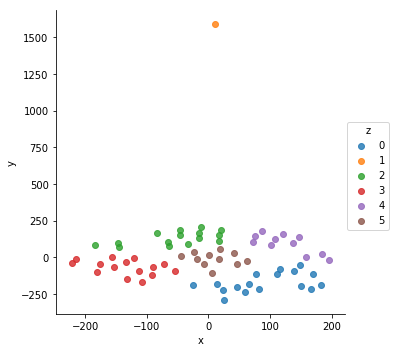

In [52]:
n_trees = 5000
print('\nTree Embedding')
t0 = time.time()
rf = rfc.RandomForestEmbedding(n_estimators=n_trees, random_state=10, n_jobs=-1, sparse_output=False)
leaves = rf.fit_transform(X)
print('Time: ' + str(time.time() - t0))


print('\nEmbedding Data')
t0 = time.time()

# if leaves.shape[1] > 50:
#     projection = TruncatedSVD(n_components=50, random_state=123).fit_transform(leaves)
# else:
#     projection = leaves.toarray()
# dissimilarity = fast_hamming_binary_sparse(leaves, n_matches=n_trees)
# projector = manifold.TSNE(random_state=1234, metric='precomputed')
projector = manifold.TSNE(random_state=1234, metric='hamming')
embedding = projector.fit_transform(leaves)


# projector = manifold.MDS(random_state=1234, dissimilarity='precomputed')
# embedding = projector.fit_transform(dissimilarity)
print('Time: ' + str(time.time() - t0))


print('\nClustering')
t0 = time.time()
clusterer = KMeans(n_clusters=num_clusters, random_state=1234, n_init=20, n_jobs=-1)
clusterer.fit(embedding)

centroids = clusterer.cluster_centers_
print('Cluster Centers:')
print_matrix(centroids)

# clusterer = KMedoids(n_clusters=num_clusters, random_state=1234, distance_metric='precomputed')
# clusterer.fit(np.load('hamming.npy'))
print('Time: ' + str(time.time() - t0) + '\n')


df = pd.DataFrame({'x': embedding[:, 0], 'y': embedding[:, 1], 'z': clusterer.labels_})
print(df)
sns.lmplot('x', 'y', hue='z', data=df, fit_reg=False)
print('\nDone')